# View Fors2 SED in original Frame

## Part 2

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/05/21
- last update : 2023/05/23
- update : 2023/09/27 @CC kernel conda_prospector_py310 
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2
              
              
              
- WRITE IN LOCAL DIRECTORY ./raw
- be carefull to path

## Import

In [1]:
import os,sys
import re
from astropy.io import fits
from astropy.table import Table

In [2]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

## Configuration

In [5]:
# imac home
#path_rootdir = "/Volumes/Backup2020/MacOSX/GitHub/LSST/fors2"
#path_rootoutdir = "/Volumes/Backup2020/MacOSX/GitHub/LSST/PhotoZ_PhD/StudyFors2SED"

In [6]:
# macbook
#path_rootdir = "/Users/dagoret/MacOSX/GitHub/LSST/fors2"
#path_rootoutdir = "/Users/dagoret/MacOSX/GitHub/LSST/LSST/PhotoZ_PhD/StudyFors2SED"

In [7]:
# imac lab
#path_rootdir = "/Users/sylvie/MacOSX/GitHub/LSST/FORS2"
#path_rootoutdir = "/Users/sylvie/MacOSX/GitHub/LSST/hotoZ_PhD/StudyFors2SED"

In [15]:
# CCIN2P3
path_rootdir = "/pbs/throng/lsst/users/dagoret/desc/StellarPopulationSynthesis/FORS2"
path_rootoutdir = "/pbs/throng/lsst/users/dagoret/desc/StellarPopulationSynthesis/PhotoZ_PhD/StudyFors2SED"

In [16]:
filename_fits_catalog = path_rootdir + '/fors2/data/fors2_catalogue.fits'
path_raw_jct          = path_rootdir + "/fors2/seds/"
path_out_jct          = path_rootoutdir + '/fors2out/seds/'
path_ana              = path_rootoutdir
path_out_sdc          = "./raw/"

In [17]:
if not os.path.exists(path_out_sdc):
    os.makedirs(path_out_sdc)

In [18]:
#filename_fits_catalog='/Users/dagoret/MacOSX/GitHub/LSST/FORS2/fors2/data/fors2_catalogue.fits'
#path_raw_jct='/Users/dagoret/MacOSX/GitHub/LSST/FORS2/fors2/seds/'
# the following path has been filled by notbook ExploreFors2.ipynb
#path_out_jct='/Users/dagoret/MacOSX/GitHub/LSST/PhotoZ_PhD/StudyFors2SED/fors2out/seds/'
#path_ana="/Users/dagoret/MacOSX/GitHub/LSST/PhotoZ_PhD/StudyFors2SED"

In [19]:
os.environ["EXT_LAW"] = 'HZ4' #prevot
#os.environ['ANA_TYPE'] = 'fors2_raw'
os.environ['ANA_TYPE'] = 'ResStarlight'
os.environ['RUN_TYPE'] = 'full'
os.environ['BASE_TAG'] = 'BC03N' #45  stars
os.environ['PLOT_TYPE'] = ''
os.environ['CONFIG_TAG'] = 'conf1'

In [20]:
ext        =os.environ['EXT_LAW']
ana_type   =os.environ['ANA_TYPE']
run_type   =os.environ['RUN_TYPE']
base_tag   =os.environ['BASE_TAG']
plot_type  =os.environ['PLOT_TYPE']
config_tag=os.environ['CONFIG_TAG']

In [21]:
#sl_path = "/Users/dagoret/MacOSX/GitHub/LSST/FORS2"
sl_path = path_rootdir
#ana_path=sl_path+'ext/'+ana_type+'/'+base_tag+'/'+config_tag+'/'+ext+'/'
ana_path=sl_path+'/'+ana_type+'/'+base_tag+'/'+config_tag+'/'+ext+'/'
ext_path=ana_path+'/extended_spectra/'
path_brown="/home/enuss/00_labo/lsst/photoZ/brown_atlas/123/"
path_brown_data=path_brown+'605/'
ext='_'+ext
  
path_SL           =ana_path+'output_sl/'


path_rebuild_BC   =ana_path       +'output_rebuild_BC/'
path_BC           =path_rebuild_BC+'full_spectra/'          #BC spectra without extinction
path_BC_ext       =path_rebuild_BC+'full_spectra_ext/'      #BC spectra with extinction
path_BC_pop_sp    =path_rebuild_BC+'population_spectra/'    #BC individual spectra without extinction
path_BC_pop_sp_ext=path_rebuild_BC+'population_spectra_ext/'#BC individual spectra with extinction
path_extinction_models='/home/enuss/00_labo/lsst/photoz/lephare/lephare_dev/ext/'

In [22]:
cat0 = fits.open(filename_fits_catalog)[0]
cat = fits.open(filename_fits_catalog)[1]

### Functions and classes

In [23]:
def get_catalog_info(spec, cat):
    try:
        spec = int(spec)
    except:
        z=-1
        lines='redshift unknown'
    if spec in cat.data['ID']:
        catid=(cat.data['ID']==spec)
        z=cat.data[catid]['z'][0]
        lines=cat.data[catid]['Lines'][0]
        ra =cat.data[catid]['RAJ2000'][0]
        dec=cat.data[catid]['DEJ2000'][0]
    else:
         z=-1
         lines='not in catalog'
         ra=0.
         dec=0.
    return z,lines,ra,dec

In [24]:
def fors2_jct_SL():
  lst=[]
  list=glob.glob(path_raw_jct+'*.txt')
  for f in list:
    base=os.path.basename(f).split('.')[0]
    id=base[4:-1]
    #print(id)
    spec=SED_jct(id)
    if (float(spec.z)!=-1) :
      lst=np.append(lst,'SPEC'+id)
      file_out=path_out_jct+'SPEC'+str(id)+'.txt'
      h=open(file_out,'w')
      x=spec.wave
      y=spec.flux
      for i in range(len(x)):
        h.write("%f %f\n"%(float(x[i]),float(y[i])))
      h.close()

  return lst  

In [25]:
class SED(object): #input SED to SL
  def __init__(self,filename,label=""):
      self.d=np.loadtxt(filename)
      self.wave=self.d[:,0]
      self.flux=self.d[:,1]
      self.label=label
  def smooth(self,size=3):
      return ndimage.filters.gaussian_filter1d(self.flux,size)
  def rescale(self,value):
      self.flux*=value
  def get_scale(self,bounds=(4150,4250)):
      start=np.searchsorted(self.wave,bounds[0])
      stop =np.searchsorted(self.wave,bounds[1])
      return self.flux[start:stop].mean()

In [26]:
class SED_jct(object):
    """
    Extract infos from catalogs and wavelength/flux from SPEC files tables (SPECXXn.txt)
    """
    def __init__(self,id,label=""):
        z,lines,ra,dec=get_catalog_info(id,cat)
        filename=path_raw_jct+'SPEC'+str(id)+'n.txt'
        self.d=np.loadtxt(filename, unpack=True)
        if (float(z)!=-1) :
            self.wave_tmp=self.d[0]/(1.+z)
        else:
            self.wave_tmp=self.d[0]*0.
        self.flux_tmp=self.d[1]
        self.mask=self.d[2]
        id_mask=np.where(self.mask==0)
        self.wave=self.wave_tmp[id_mask]
        self.flux=self.flux_tmp[id_mask]      
        self.label=label
        self.z=z
        self.lines=lines
        self.ra=ra
        self.dec=dec
        
    def get_scale(self,bounds=(4150,4250)):
        start=np.searchsorted(self.wave,bounds[0])
        stop=np.searchsorted(self.wave,bounds[1])
        return self.flux[start:stop].mean()

In [27]:
class SED_sdc(object):
    """
    Extract infos from catalogs and wavelength/flux from SPEC files tables (SPECXXn.txt)
    """
    def __init__(self,id,label=""):
        z,lines,ra,dec=get_catalog_info(id,cat)
        filename=path_raw_jct+'SPEC'+str(id)+'n.txt'
        
        self.d=np.loadtxt(filename, unpack=True)
        
        
        #if (float(z)!=-1) :
        #    self.wave_tmp=self.d[0]/(1.+z)
        #else:
        #    self.wave_tmp=self.d[0]*0.
            
        self.wave_tmp=self.d[0]    
        self.flux_tmp=self.d[1]
        self.mask=self.d[2]
        
        id_mask=np.where(self.mask==0)
        
        self.wave=self.wave_tmp[id_mask]
        self.flux=self.flux_tmp[id_mask]      
        self.label=label
        self.z=z
        self.lines=lines
        self.ra=ra
        self.dec=dec
        
    def get_scale(self,bounds=(4150,4250)):
        start=np.searchsorted(self.wave,bounds[0])
        stop=np.searchsorted(self.wave,bounds[1])
        return self.flux[start:stop].mean()

In [28]:
def fors2_sdc_NOSL():
  lst=[]
  list=glob.glob(path_raw_jct+'*.txt')
  for f in list:
    base=os.path.basename(f).split('.')[0]
    id=base[4:-1]
    #print(id)
    spec=SED_sdc(id)
    if (float(spec.z)!=-1) :
      lst=np.append(lst,'SPEC'+id)
      file_out=path_out_sdc+'SPEC'+str(id)+'_raw_sdc.txt'
      h=open(file_out,'w')
      x=spec.wave
      y=spec.flux
      for i in range(len(x)):
        h.write("%f %f\n"%(float(x[i]),float(y[i])))
      h.close()

  return lst  

## Catalog

In [29]:
#cat0.header

In [30]:
cat.fileinfo()

{'file': <astropy.io.fits.file._File <_io.BufferedReader name='/pbs/throng/lsst/users/dagoret/desc/StellarPopulationSynthesis/FORS2/fors2/data/fors2_catalogue.fits'>>,
 'filemode': 'readonly',
 'hdrLoc': 5760,
 'datLoc': 14400,
 'datSpan': 97920}

In [31]:
data = cat.data

In [32]:
cols = data.columns

In [33]:
print(cols)

ColDefs(
    name = 'ID'; format = 'I4'; start = 2
    name = 'm_ID'; format = 'A1'; start = 7
    name = 'RAJ2000'; format = 'F9.5'; unit = 'deg'; start = 9
    name = 'DEJ2000'; format = 'F9.5'; unit = 'deg'; start = 19
    name = 'z'; format = 'F7.5'; start = 29
    name = 'u_z'; format = 'A1'; start = 37
    name = 'Rmag'; format = 'F5.2'; unit = 'mag'; null = 'NaN'; start = 39
    name = 'RV'; format = 'I7'; unit = 'km/s'; start = 45
    name = 'e_RV'; format = 'I4'; unit = 'km/s'; start = 53
    name = 'RT'; format = 'F4.1'; null = 'NaN'; start = 58
    name = 'Nsp'; format = 'I1'; start = 63
    name = 'Lines'; format = 'A76'; start = 65
)


### Better using astropy tables

In [34]:
t = Table.read(filename_fits_catalog)

In [35]:
t

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
1,,13.52815,-28.40486,0.55409,,20.79,166227,55,10.0,1,"[OII],H8,K,H"
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"
3,,13.52552,-28.4208,0.6866,,21.45,210642,48,11.6,4,"[OII],H9,K,H,H{beta},[OIII],H8"
4,,13.52216,-28.40914,0.68653,,21.62,205959,123,10.6,1,"[OII],H9,K,H,G,H{beta}"
7,,13.50974,-28.42972,0.32371,,22.34,97111,11,16.7,6,"[OII],H{beta},[OIII],H{alpha}"
9,,13.50219,-28.40641,0.29266,,21.6,87798,58,13.1,1,"H9,H8,K,H"
11,,13.49724,-28.39487,0.62688,,22.09,188063,17,24.3,3,"[OII],H10,H8,K,H,H{delta}"
12,,13.49584,-28.39125,0.2973,,21.97,89189,30,14.8,2,"[OII],H10,H9,H8,K,H"


# View Fors2 spectra and Extended Spectra

In [36]:
list_of_spectra = fors2_sdc_NOSL()

In [37]:
print(list_of_spectra)

['SPEC37' 'SPEC85' 'SPEC526' 'SPEC595' 'SPEC583' 'SPEC282' 'SPEC326'
 'SPEC221' 'SPEC351' 'SPEC543' 'SPEC443' 'SPEC677' 'SPEC468' 'SPEC240'
 'SPEC115' 'SPEC31' 'SPEC672' 'SPEC338' 'SPEC601' 'SPEC334' 'SPEC424'
 'SPEC306' 'SPEC197' 'SPEC210' 'SPEC191' 'SPEC643' 'SPEC323' 'SPEC681'
 'SPEC591' 'SPEC446' 'SPEC344' 'SPEC425' 'SPEC717' 'SPEC628' 'SPEC621'
 'SPEC363' 'SPEC109' 'SPEC47' 'SPEC531' 'SPEC372' 'SPEC128' 'SPEC590'
 'SPEC423' 'SPEC632' 'SPEC685' 'SPEC71' 'SPEC454' 'SPEC222' 'SPEC287'
 'SPEC606' 'SPEC490' 'SPEC346' 'SPEC227' 'SPEC510' 'SPEC500' 'SPEC30'
 'SPEC428' 'SPEC305' 'SPEC715' 'SPEC62' 'SPEC726' 'SPEC569' 'SPEC524'
 'SPEC722' 'SPEC602' 'SPEC196' 'SPEC324' 'SPEC684' 'SPEC233' 'SPEC2'
 'SPEC32' 'SPEC571' 'SPEC141' 'SPEC692' 'SPEC398' 'SPEC93' 'SPEC671'
 'SPEC593' 'SPEC438' 'SPEC460' 'SPEC388' 'SPEC463' 'SPEC676' 'SPEC729'
 'SPEC371' 'SPEC260' 'SPEC449' 'SPEC242' 'SPEC694' 'SPEC459' 'SPEC451'
 'SPEC358' 'SPEC674' 'SPEC61' 'SPEC706' 'SPEC634' 'SPEC112' 'SPEC540'
 'SPEC455' 'SPEC36

In [38]:
spectra_numbers1 = sorted([int(re.findall('^SPEC(.*)$',spec)[0]) for spec in list_of_spectra ])

In [39]:
list_sedoriginalframefilenames_sdc = os.listdir(path_out_sdc)

In [40]:
spectra_numbers2 = sorted([int(re.findall('^SPEC(.*)_raw_sdc[.]txt$',fname)[0]) for fname in list_sedoriginalframefilenames_sdc ])

### Check the consistency of both lists

In [41]:
spectra_numbers1 == spectra_numbers2

True

### another long way to check the consistency of both lists

In [42]:
for thespecfilename in list_sedoriginalframefilenames_sdc:
    cut0 = str(thespecfilename.split(".")[0])
    rcut = r"{cut0}"
    if rcut in list_of_spectra:
        print(f" BAD : filename {thespecfilename} : {cut0} not found in list_of_spectra") 
    else:
        #print(f" GOOD : filename {thespecfilename} : {cut0} found in list_of_spectra") 
        pass

In [43]:
for specbase in list_of_spectra:
    flag_found=False
    for fname in list_sedoriginalframefilenames_sdc:
        cut0 = str(fname.split("_")[0])
        #rcut = r"{cut0}"
        if specbase == cut0:
            flag_found = True
            break
    if not flag_found:
        print(f" BAD : {specbase} :  not found in list_sedrestframefilenames_sdc")      

# Compare the SL spectra with the restframe spectra

In [44]:
t[t["ID"] == 2]

ID,m_ID,RAJ2000,DEJ2000,z,u_z,Rmag,RV,e_RV,RT,Nsp,Lines
,,deg,deg,,,mag,km / s,km / s,,,
int16,bytes1,float64,float64,float64,bytes1,float64,int32,int16,float64,int16,bytes77
2,,13.52997,-28.44776,0.34555,,21.18,103665,40,12.3,1,"K,H,G,H{beta}"


In [45]:
for specnum in [160]:
    filename = f"SPEC{specnum}_raw_sdc.txt"
    filename2 = f"SPEC{specnum}_HZ4_BC.txt"
    filetag = f"SPEC{specnum}"
    flag_sel = t["ID"] == specnum 
    trow = t[flag_sel]
    redshift=trow["z"]
    lines=trow["Lines"]
    ra = trow["RAJ2000"]
    dec= trow["DEJ2000"]
    the_sed = SED(os.path.join(path_out_sdc,filename))
    the_sed2= SED(os.path.join(path_BC,filename2))
    
    break
    
   

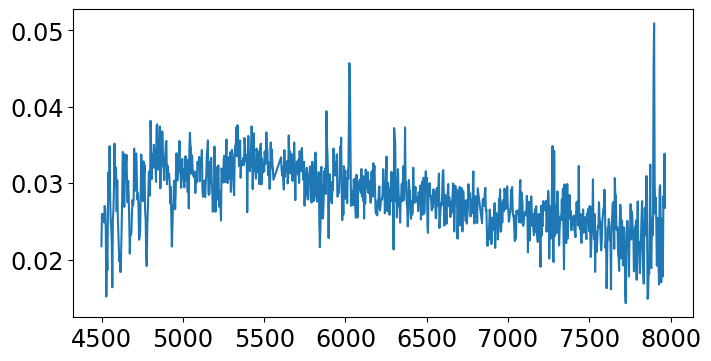

In [46]:
plt.plot(the_sed.wave,the_sed.flux)

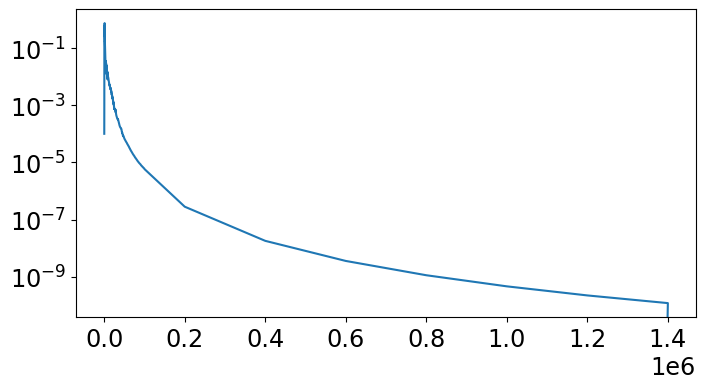

In [47]:
#plt.plot(arr[:,0],arr[:,1])
plt.plot(the_sed2.wave,the_sed2.flux)
#plt.xlim(arr[:,0].min(),arr[:,0].max())
filetag
plt.yscale("log")